## Active Appearance Models (Intermediate results)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.spatial import ConvexHull
import cv2
from helper_functions import procrustes_align, AffineRegistrationLandmarks, generalized_procrustes_analysis, applyTransformation, rescale_to_original, inverse_warping

In [2]:
# Loading data
Working_directory=""
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    Landmarks = data['Landmarks_FEI'] # original landmarks
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']
N,M = Landmarks.shape # number subjects
H, W = Images.shape[1:]
dim = 2
M = int(M/dim) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M)
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


# Designing the covariate model for shape and texture

(136,)
Iter number 1 , Error: 0.000585


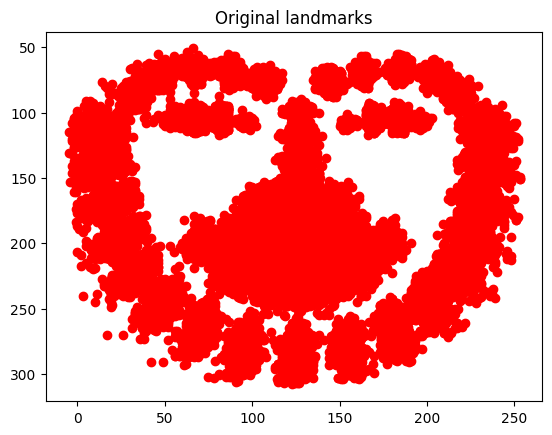

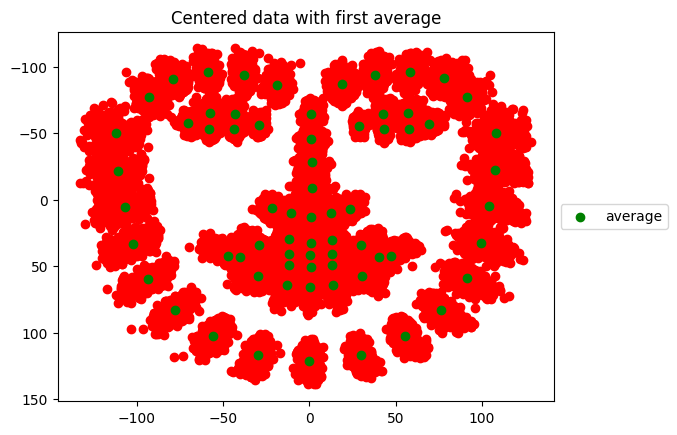

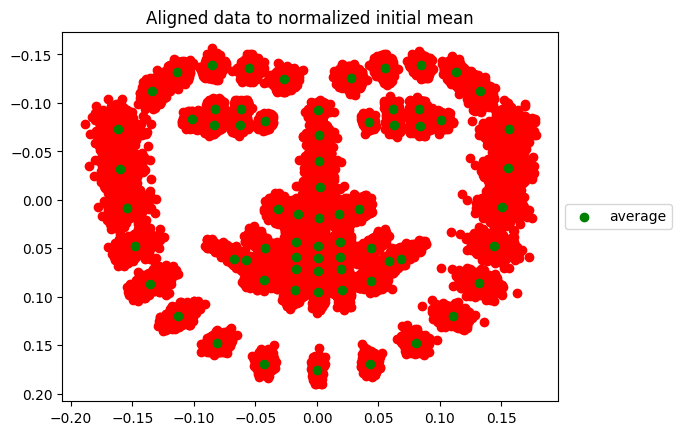

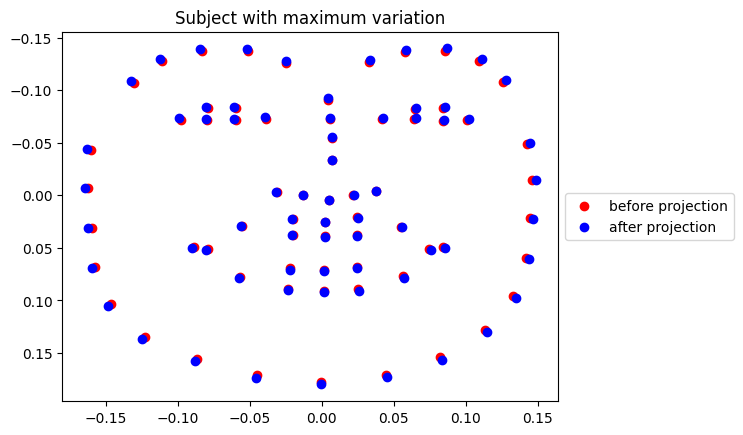

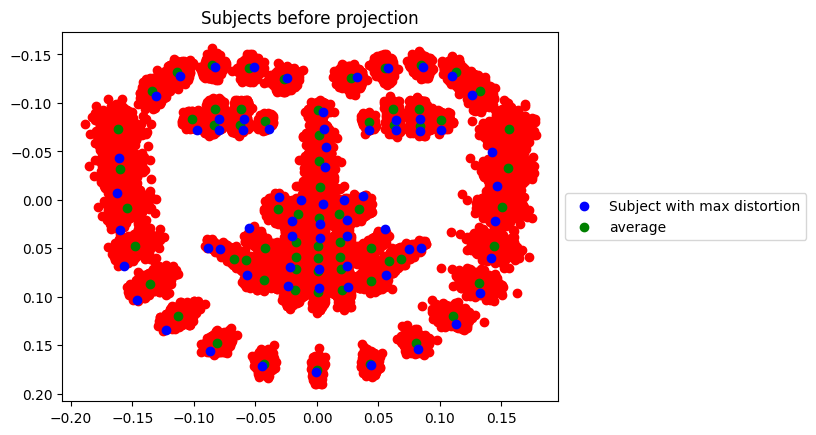

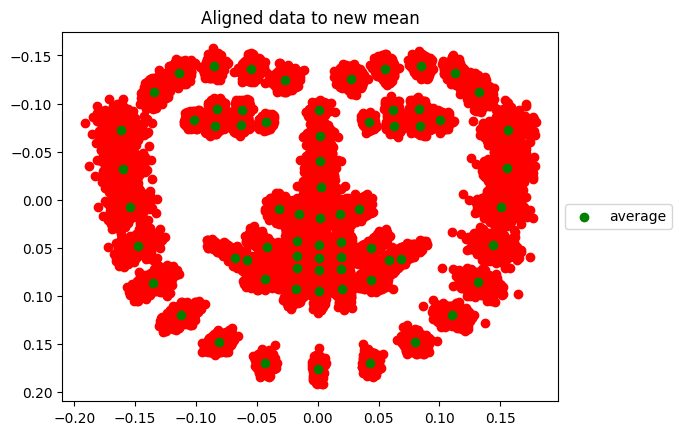

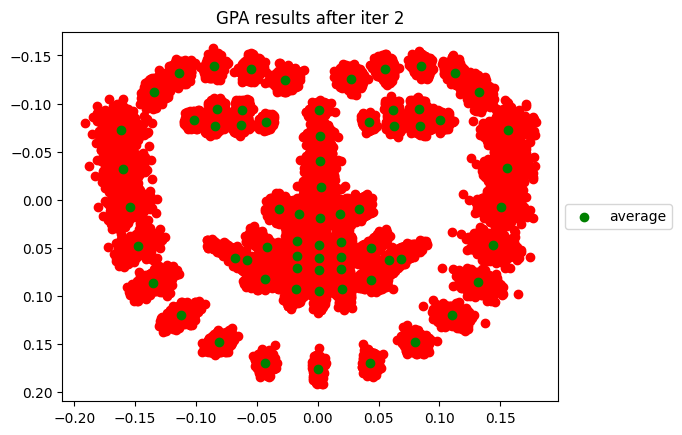

In [3]:
#  GPA (Generalized Procrustes Analysis)
X_sf, Xm1  = generalized_procrustes_analysis(Landmarks,tangent=1) #Sf for Shape free

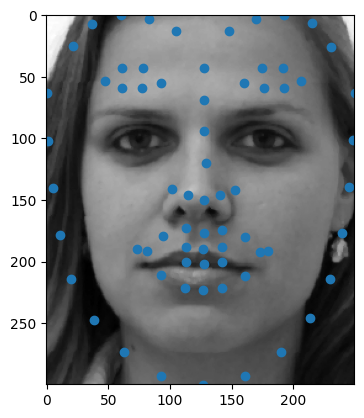

In [4]:
Is = Images[0]
Xm1_rescaled = rescale_to_original(Xm1.reshape(-1,2),H,W)
plt.scatter(Xm1_rescaled[:,0],Xm1_rescaled[:,1])
plt.imshow(Is, cmap='gray')
plt.show()

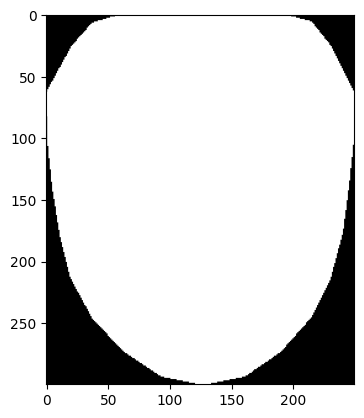

In [5]:
hull = ConvexHull(Xm1_rescaled)

hull_points = Xm1_rescaled[hull.vertices]

mask = np.zeros((H,W))

cv2.fillPoly(mask,[hull_points],1)

plt.imshow(mask,cmap='gray')

plt.show()

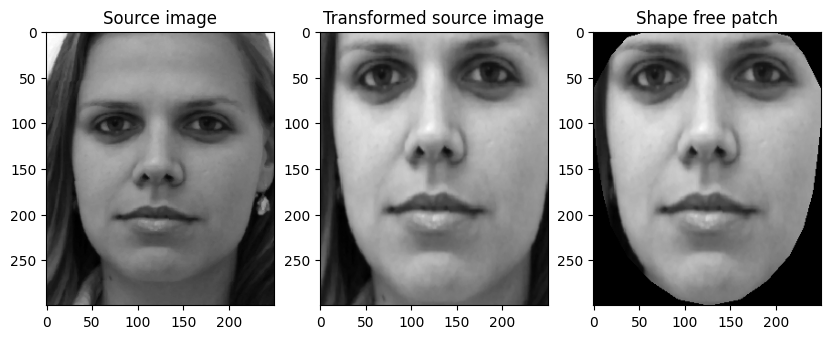

In [6]:
x_0 = Landmarks[0]
_, T = AffineRegistrationLandmarks(x_0.reshape(-1,2),Xm1_rescaled)

Ism = inverse_warping(Is,T,H,W)

fig = plt.figure(figsize=(10, 15))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
ax1.imshow(Is, cmap='gray')
ax1.set_title('Source image')
ax2.imshow(Ism, cmap='gray')
ax2.set_title('Transformed source image')
ax3.imshow(Ism*mask, cmap='gray')
ax3.set_title('Shape free patch')
plt.show()

In [14]:
#Converting all images to shape free images
SF_images = np.zeros((N,H,W))
for i in range(N):
    image = Images[i]
    landmark = Landmarks[i]
    _, T = AffineRegistrationLandmarks(landmark.reshape(-1,2),Xm1_rescaled)
    shape_free_image = inverse_warping(image, T, H, W)
    shape_free_image = shape_free_image*mask
    SF_images[i] = shape_free_image

In [19]:
#Converting all images to shape free images
n_non_zero = len(np.nonzero(mask)[0])
SF_patches = np.zeros((N,n_non_zero))
for i in range(N):
    image = Images[i]
    landmark = Landmarks[i]
    _, T = AffineRegistrationLandmarks(landmark.reshape(-1,2),Xm1_rescaled)
    shape_free_image = inverse_warping(image, T, H, W)
    shape_free_image = shape_free_image[mask>0]
    SF_patches[i] = shape_free_image

In [27]:
SF_landmarks = np.zeros((N,2*M))
for i in range(N):
    landmark = Landmarks[i]
    sf_landmark, T = AffineRegistrationLandmarks(landmark.reshape(-1,2),Xm1_rescaled)
    SF_landmarks[i] = sf_landmark.reshape(-1)

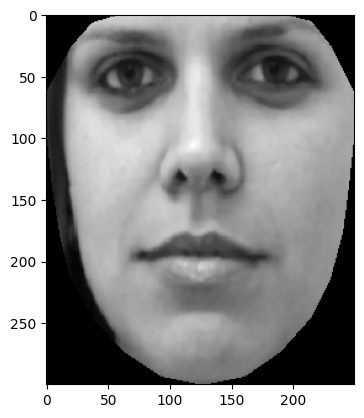

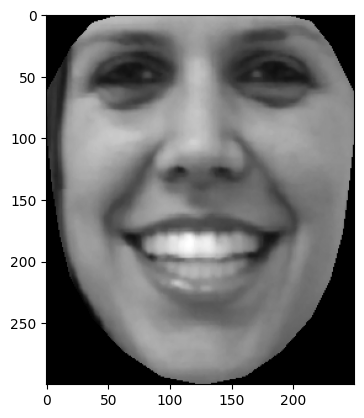

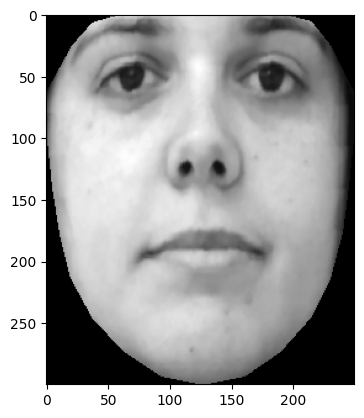

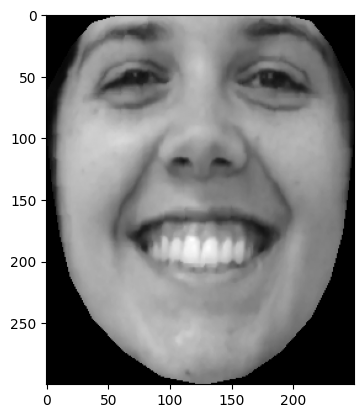

In [8]:
for i in range(4):
    plt.imshow(SF_images[i],cmap='gray')
    plt.show()

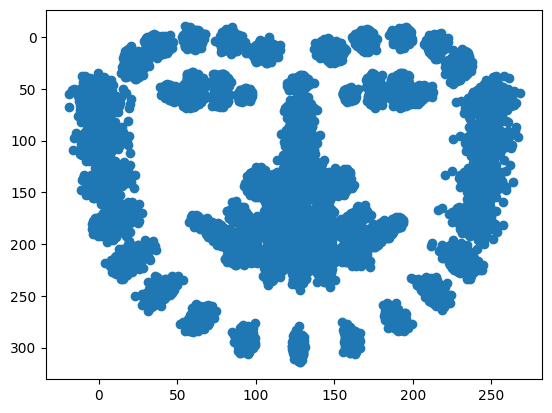

In [28]:
plt.scatter(SF_landmarks[:,::2].reshape(-1),SF_landmarks[:,1::2].reshape(-1))
plt.gca().invert_yaxis()
plt.show()

In [145]:
shape_size = SF_landmarks.shape[1]
texture_size = SF_patches.shape[1]
renormalization_factor = np.sqrt(1/texture_size)
print(shape_size,texture_size)

136 61966


In [204]:
SF_patch_normalized = SF_patches/np.std(SF_patches,axis=0)
design_matrix = np.concatenate((SF_landmarks,renormalization_factor*SF_patches),axis=-1)
mean = np.mean(design_matrix,axis=0)
std = np.std(design_matrix,axis=0)
design_matrix = design_matrix-mean

In [194]:
print(design_matrix.shape)
print(mean.shape)
print(std.shape)

(400, 62102)
(62102,)
(62102,)


In [205]:
# Shape variability analysis
from sklearn.decomposition import PCA

pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Y=pca.fit_transform(design_matrix)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(N-1) # computation of the eigenvalues
var_explained = pca.explained_variance_ratio_*100 # variance explained

print(U.shape)
print('The first three modes explain %f, %f and %f of the total variability respectively' % (var_explained[0], var_explained[1], var_explained[2]))

(62102, 400)
The first three modes explain 29.335705, 27.689590 and 10.663937 of the total variability respectively


11


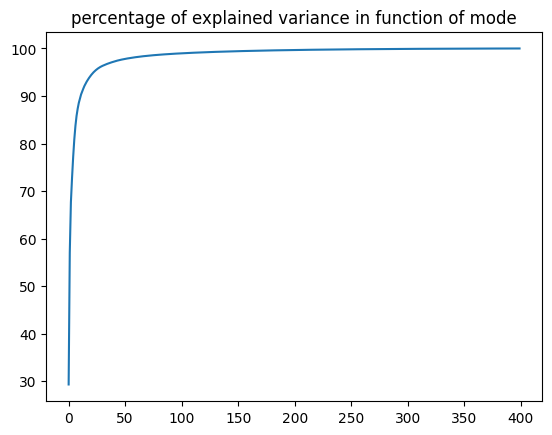

In [206]:
c = np.cumsum(var_explained)
print(np.where(c>=90)[0][0])
plt.plot(c)
plt.title("percentage of explained variance in function of mode")
plt.show()

In [197]:
# Compute first mode
first_mode_m = mean - 3*np.sqrt(D[0])*U[:,0]
first_mode_p = mean + 3*np.sqrt(D[0])*U[:,0]

In [198]:
print(first_mode_m.shape)
shape_m = first_mode_m[:shape_size]
texture_m = first_mode_m[shape_size:]
shape_p = first_mode_p[:shape_size]
texture_p = first_mode_p[shape_size:]

(62102,)


In [199]:
image_m = np.zeros((H,W))
image_m[mask>0] = texture_m
image_p = np.zeros((H,W))
image_p[mask>0] = texture_p

(62102,)


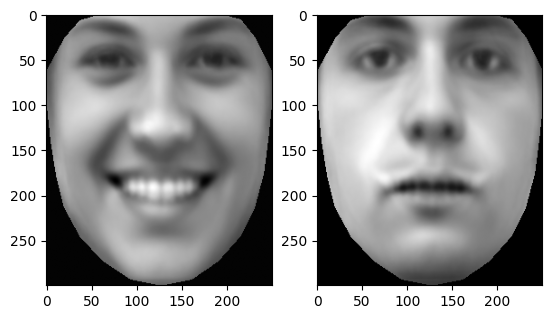

(62102,)


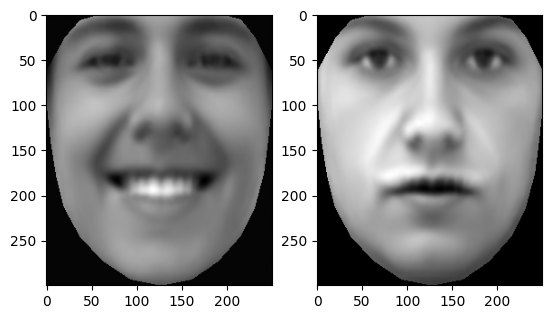

(62102,)


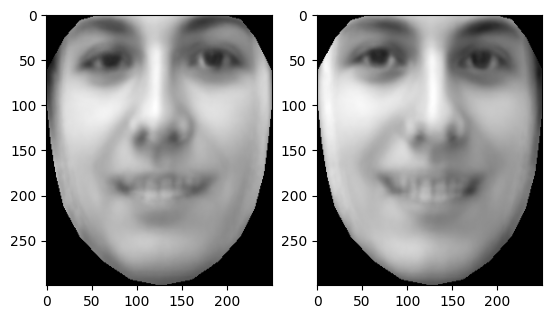

(62102,)


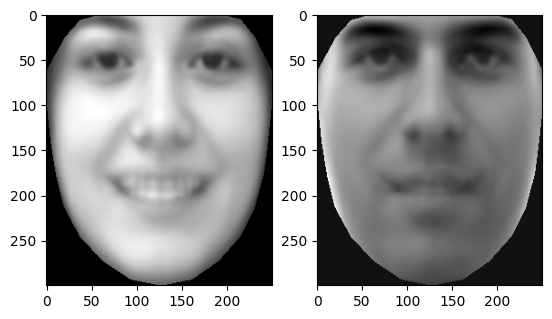

(62102,)


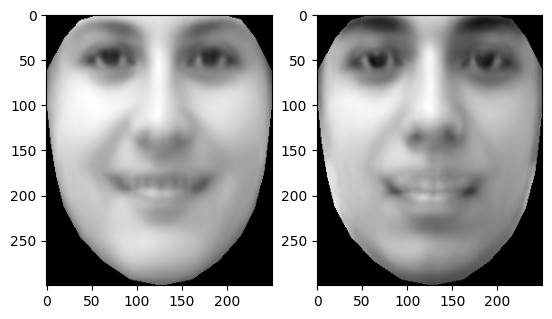

(62102,)


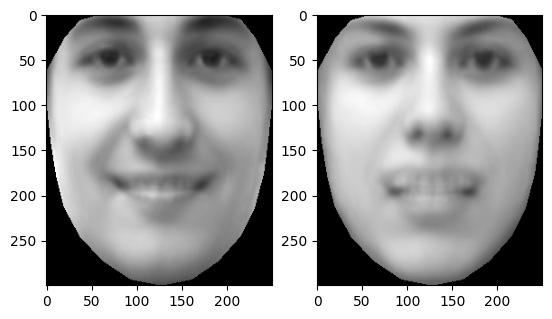

(62102,)


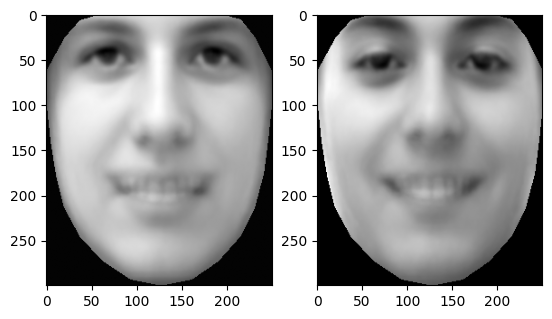

(62102,)


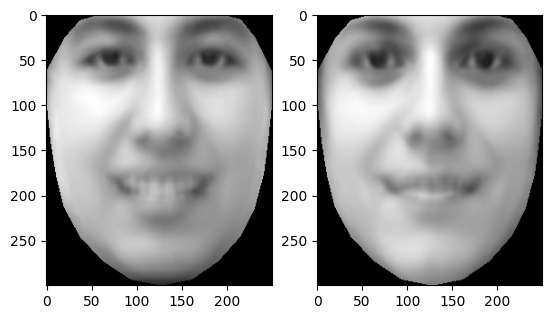

(62102,)


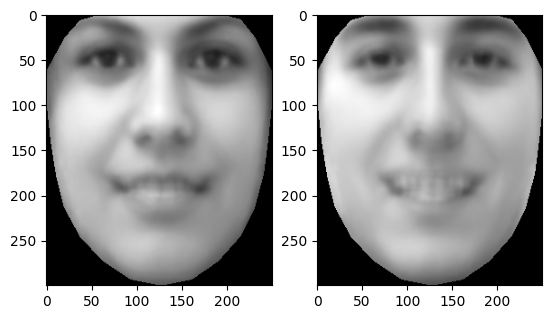

(62102,)


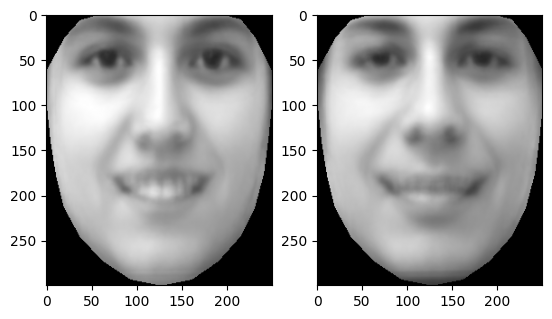

In [216]:
# Compute mode
for mode in range(10):
    first_mode_m = mean - 3*np.sqrt(D[mode])*U[:,mode]
    first_mode_p = mean + 3*np.sqrt(D[mode])*U[:,mode]
    
    print(first_mode_m.shape)
    shape_m = first_mode_m[:shape_size]
    texture_m = first_mode_m[shape_size:]
    shape_p = first_mode_p[:shape_size]
    texture_p = first_mode_p[shape_size:]
    
    image_m = np.zeros((H,W))
    image_m[mask>0] = texture_m
    image_p = np.zeros((H,W))
    image_p[mask>0] = texture_p
    
    plt.subplot(1,2,1)
    plt.imshow(image_p,cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(image_m,cmap='gray')
    plt.show()

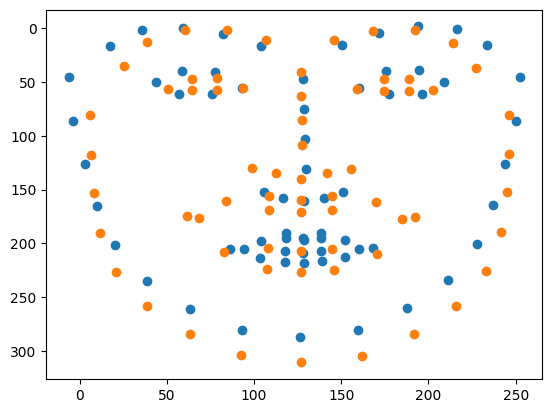

In [192]:
plt.scatter(shape_m[::2],shape_m[1::2])
plt.scatter(shape_p[::2],shape_p[1::2])
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# # Compute first mode
# first_mode_m= Xm1 - 3*np.sqrt(D[0])*U[:,0]
# first_mode_p= Xm1 + 3*np.sqrt(D[0])*U[:,0]

# # Compute second mode
# second_mode_m= Xm1 - 3*np.sqrt(D[1])*U[:,1]
# second_mode_p= Xm1 + 3*np.sqrt(D[1])*U[:,1]
# # Compute third mode
# third_mode_m= Xm1 - 3*np.sqrt(D[2])*U[:,2]
# third_mode_p= Xm1 + 3*np.sqrt(D[2])*U[:,2]

# if show_plot==1:
#     plt.figure()
#     plt.subplot(1, 3, 1)
#     plt.scatter(first_mode_m[::2], first_mode_m[1::2], c='r')
#     plt.xlabel('- 3 std')
#     plt.gca().invert_yaxis()
#     plt.subplot(1, 3, 2)
#     plt.scatter(Xm1[::2], Xm1[1::2], c='g')
#     plt.xlabel('average')
#     plt.title('First mode of deformation')
#     plt.gca().invert_yaxis()
#     plt.subplot(1, 3, 3)
#     plt.scatter(first_mode_p[::2], first_mode_p[1::2], c='r')
#     plt.xlabel('+ 3 std')
#     plt.gca().invert_yaxis()

#     plt.figure()
#     plt.subplot(1, 3, 1)
#     plt.scatter(second_mode_m[::2], second_mode_m[1::2], c='r')
#     plt.xlabel('- 3 std')
#     plt.gca().invert_yaxis()
#     plt.subplot(1, 3, 2)
#     plt.scatter(Xm1[::2], Xm1[1::2], c='g')
#     plt.xlabel('average')
#     plt.title('Second mode of deformation')
#     plt.gca().invert_yaxis()
#     plt.subplot(1, 3, 3)
#     plt.scatter(second_mode_p[::2], second_mode_p[1::2], c='r')
#     plt.xlabel('+ 3 std')
#     plt.gca().invert_yaxis()

#     plt.figure()
#     plt.subplot(1, 3, 1)
#     plt.scatter(third_mode_m[::2], third_mode_m[1::2], c='r')
#     plt.xlabel('- 3 std')
#     plt.gca().invert_yaxis()
#     plt.subplot(1, 3, 2)
#     plt.scatter(Xm1[::2], Xm1[1::2], c='g')
#     plt.xlabel('average')
#     plt.title('Third mode of deformation')
#     plt.gca().invert_yaxis()
#     plt.subplot(1, 3, 3)
#     plt.scatter(third_mode_p[::2], third_mode_p[1::2], c='r')
#     plt.xlabel('+ 3 std')
#     plt.gca().invert_yaxis()